# Kernel Density Estimation
Shaney Flores

The goal of this project is to implement several different kernel density estimation procedures that will estimate the density of a sample of randomly generated values. We will then plot the results, showing the true density function, our estimate, and the sample points. To help with readability, we will jitter the sample points along the x-axis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

SEED = 42
rng = np.random.default_rng(SEED)

"""
Plot True and Estimated Density Functions

x      : test data
y      : true values for test data
y_hat  : estimated values for test data
X      : training data
n      : size of training data
xlm    : lower, upper limits for x-axis
k      : kth neighbor (default=None)
"""
def density_plot(ax, x, y, y_hat, X, xlm, k=None):
    n = X.shape[0]
    ax.plot(x, y, label="true density", color="blue") 
    ax.plot(x, y_hat, label="estimated density", color="orange") 
    ax.scatter(X, rng.uniform(0,0.02,size=(n,1)), color="black", label="training data", zorder=2, s=14.)
    ax.set_title("N = %i" % n) if k is None else ax.set_title("K = %i , N = %i" % (k, n))
    ax.set_xlim(xlm)


## Q1

The task is to implement density estimation using the K-NN method. Obtain an iid sample of *N* $\ge$ 1 points from a univariate normal (Gaussian) distribution (let us call the random variable X) centered at 1 and with variance 2. Now, empirically obtain an estimate of the density from the sample points using the K-NN method, for any value of *K*, where 1 $\le$ *K* $\le$ *N*. Produce one plot for each of the following cases (each plot should show the following three items: the *N* data points (instances or realizations of X) and the true and estimated densities versus x for a large number – e.g., 1000, 10000 – of discrete, linearly-spaced x values): (K = N = 1), (K = 2, N = 10), (K = 10, N = 10), (K = 10, N = 1000), (K = 100, N = 1000), (K = N = 50,000).

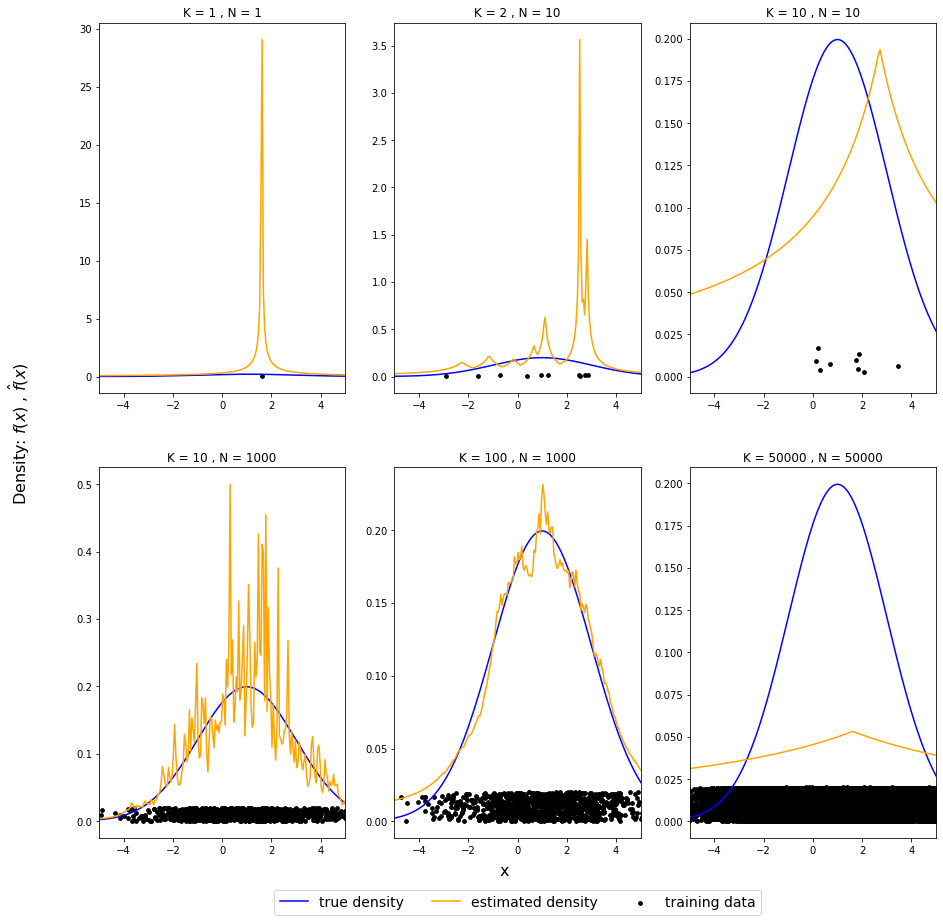

In [2]:
mu = 1
std = 2

K = [1,  2, 10,   10,  100, 50000]
N = [1, 10, 10, 1000, 1000, 50000]
x = np.linspace(-25, 25, num=1000)
y = stats.norm(mu,std).pdf(x)
kn = np.vstack((K, N)).T
fig, ax = plt.subplots(int(len(kn) / 3), 3, figsize=(15,15))

"""
Perform K-NN 1D Density Estimation

x_train : training data
x_test  : test data
k       : kth neighbor
n       : size of training data
"""
def knn_1de(x_train, x_test, k, n):
    return ( 1 / (2 * np.sort( abs(x_train.reshape(1,-1) - x_test.reshape(-1,1)), axis=1 )[:,k-1] )) * (k / n)

## KNN with sampling from a normal density 
for p in range(len(kn)):
    r = int(p / 3)
    c = int(p % 3)
    X = rng.normal(mu, std, size=kn[p,1])  
    y_hat = knn_1de(X, x, kn[p,0], kn[p,1])
    density_plot(ax[r,c], x, y, y_hat, X, [-5, 5], kn[p,0])
    
ax.flatten()[-2].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.12), fontsize=14)
fig.text(0.5, 0.09, 'x', ha='center', size=16)
fig.text(0.04, 0.5, 'Density: $f(x)$ , $\hat{f}(x)$', size=16, va='center', rotation='vertical')
plt.show()    

## Q2

Repeat Q1 (i.e., produce six more plots) by replacing the Gaussian density with the following mixture of two uniform densities:

<p><center>$f(x)$ = 0.4$f_{1}(x)$ + 0.6$f_{2}(x)$</center></p>

where

<p><center>$f_{1}(x) = \begin{cases} 1 & 2 \le x \le 3 \\ 0 & otherwise  \end{cases}$</center></p>

and

<p><center>$f_{2}(x) = \begin{cases} 0.2 & 15 \le x \le 20 \\ 0 & otherwise \end{cases}$</center></p>


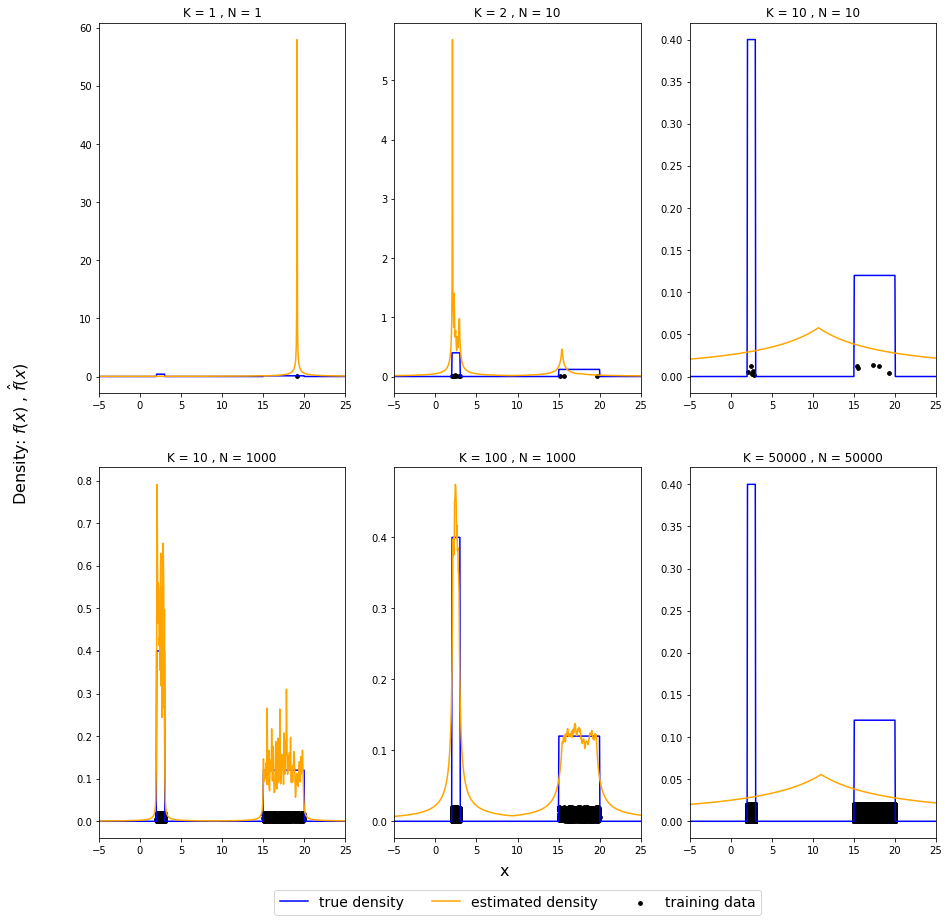

In [3]:
from statsmodels.distributions.mixture_rvs import mixture_rvs
fig, ax = plt.subplots(int(len(kn) / 3), 3, figsize=(15,15))

def f1(v):
    return np.where((v>=2)&(v<=3) , 1., 0)

def f2(v):
    return np.where((v>=15)&(v<=20) , 0.2, 0)

"""
Obtain sample from a mixture density function

n      : size of training data
"""
def mixture_sample(n):
    return mixture_rvs(prob=[0.4,0.6], size=n, 
                dist=[stats.uniform, stats.uniform], 
                kwargs=(dict(loc=2,scale=1), dict(loc=15,scale=5))) 

## calculate true y values
y = 0.4 * f1(x) + 0.6 * f2(x)

## KNN with sampling from a mixture density 
for p in range(len(kn)):
    r = int(p / 3)
    c = int(p % 3)
    X = mixture_sample(kn[p,1]) 
    y_hat = knn_1de(X, x, kn[p,0], kn[p,1])
    density_plot(ax[r,c], x, y, y_hat, X, [-5, 25], kn[p,0])

ax.flatten()[-2].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.12), fontsize=14)
fig.text(0.5, 0.09, 'x', ha='center', size=16)
fig.text(0.04, 0.5, 'Density: $f(x)$ , $\hat{f}(x)$', size=16, va='center', rotation='vertical')
plt.show()  

## Q3

Estimate the (mixture-)density $f(x)$ (that was used in Q2) using the kernel method (use Gaussian kernel). That is, first obtain an iid sample of *N* $\ge$ 1 points from the true density $f(x)$, and then obtain, by Gaussian KDE, an estimate of $f(x)$ using those *N* sample points. Produce plots (each plot showing the data points and the true and the estimated densities), one plot for each of the following sample sizes (note: sample size = N): 1, 2, 5, 10, 50, 100, 1000. 

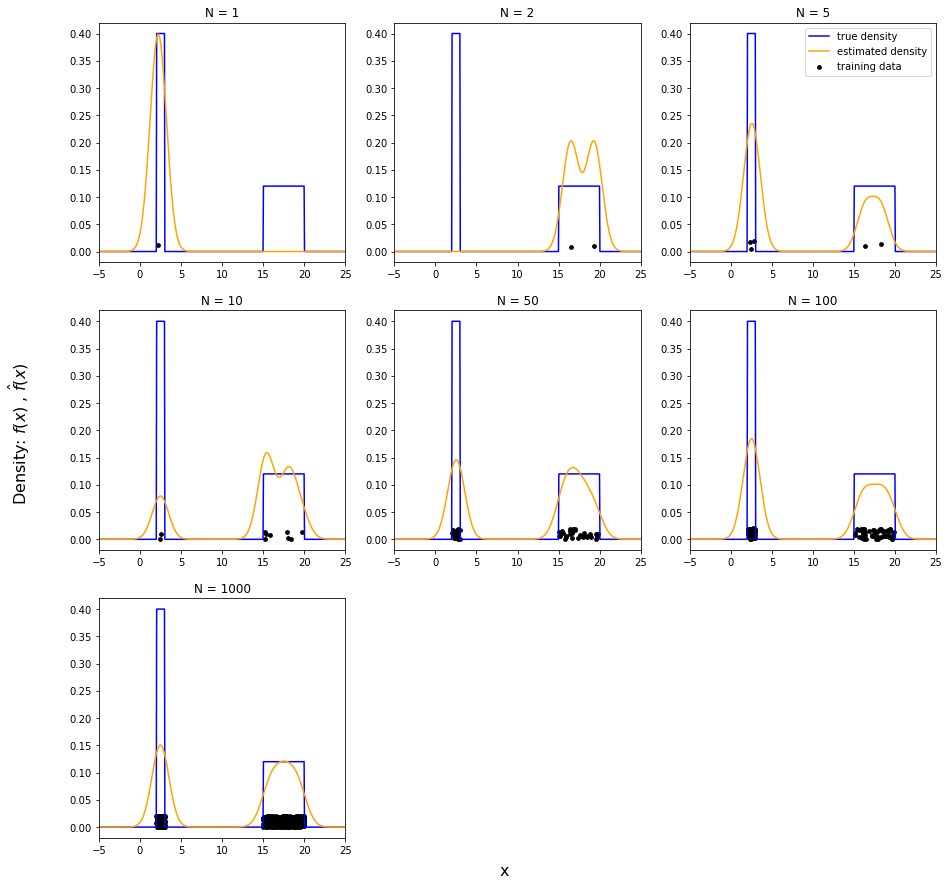

In [4]:
N = [1, 2, 5, 10, 50, 100, 1000]
fig, ax = plt.subplots(int(len(N) / 3)+1, 3, figsize=(15,15))

"""
Perform Gaussian Kernel Density Estimation

u      : difference between training and test data points
n      : size of training data
h      : bandwith (default=1 for standard normal)
"""
def gaussian_kde(u, n, h=1):
    return np.sum( np.exp(-0.5 * pow(u/h,2)) / np.sqrt(2 * np.pi), axis=1 ) / (h * n)

## Gaussian KDE with sampling from a mixture density
for p in range(len(N)):
    r = int(p / 3)
    c = int(p % 3)
    X = mixture_sample(N[p]) 
    y_hat = gaussian_kde( X.reshape(1,-1) - x.reshape(-1,1), N[p] )
    density_plot(ax[r,c], x, y, y_hat, X, [-5, 25])
    
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])
ax[0,2].legend()
fig.text(0.5, 0.09, 'x', ha='center', size=16)
fig.text(0.04, 0.5, 'Density: $f(x)$ , $\hat{f}(x)$', size=16, va='center', rotation='vertical')
plt.show() 

## Q4

Repeat Q3 by replacing the KDE method by the histogram method. Show a plot of the histogram, separately for three sample sizes 5, 10, 500 with 2, 5, and 20 bins used for each sample size.

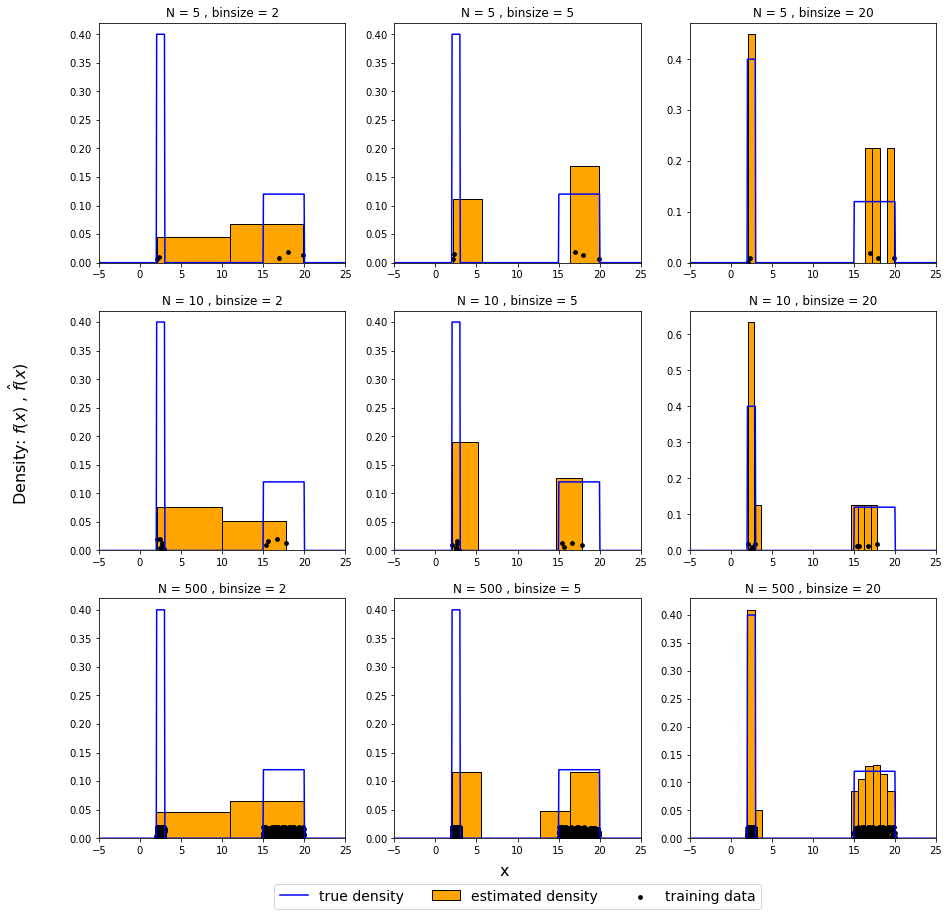

In [5]:
N = [5, 10, 500]
binsize = [2, 5, 20]

fig, ax = plt.subplots(len(N), len(binsize), figsize=(15,15))

## histogram with sampling from a mixture density
for i, n in enumerate(N):
    X = mixture_sample(n) # ensure same sample for each bin size
    for j, bins in enumerate(binsize):
        ax[i, j].hist(X, bins=bins, label="estimated density", color="orange", ec="black", density=True) 
        ax[i, j].plot(x, y, label="true density", color="blue")
        ax[i, j].scatter(X, rng.uniform(0,0.02, size=(n,1)), color="black", label="training data", zorder=2, s=14.)
        ax[i, j].set_title("N = %i , binsize = %i" % (n,bins))
        ax[i, j].set_xlim([-5,25])
        
ax.flatten()[-2].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.16), fontsize=14)
fig.text(0.5, 0.09, 'x', ha='center', size=16)
fig.text(0.04, 0.5, 'Density: $f(x)$ , $\hat{f}(x)$', size=16, va='center', rotation='vertical')
plt.show()